In [121]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


42.1226856

In [130]:
def eos_core_15(p, T):
    """
    EOS for bcc iron - silicate (FeSi15) computes volume, density, thermal expansivity, heat capacity at constant P, 
    Grüneisen parameter, and isothermal incompressibility.
    """
    # Constants
    #----------------------------------------------------------------------------------------------------------
    T0 = 300.0  # Reference temperature [K]
    MFe = 55.845  # Molar mass [g/mol]
    MSi = 28.0855  # Molar mass [g/mol]
    V0 = 13569.088754628  # mm^3/mol
    KT0 = 227.9 # Bulk modulus at reference [GPa]
    KTP = 4.74  # Pressure derivative of bulk modulus
    gamma0 = 1.408  # Grüneisen parameter at reference 1.9547
    gammaInf = 0.827  # Grüneisen parameter at infinite compression
    beta = 0.826  # Parameter for gamma
    theta0 = 44.574  # Einstein temperature at reference [K]
    a0 = 2.121e-4  # Anharmonic parameter
    m = 1.891  # Anharmonic exponent
    g = 1.339  # Parameter for thermal contribution
    R = 8.3144621  # Gas constant [J/mol/K]
    XFe = (85/55.845)/(85/55.845 + 15/28.0855)  # Molar fraction Fe-7Si
    XSi = 1.0 - XFe  # Molar fraction Fe-7Si
    Z = XFe*26.0 + XSi*14 # average Atomic number
    M0 = (XFe*MFe + XSi*MSi)*2*1.0e6  # molar mass [mug/mol]

    # Derived quantities
    PFG0 = 0.10036e9 * (Z / V0) ** (5.0 / 3.0)
    c0 = -np.log(3.0 * KT0 / PFG0)
    c2 = 3.0 / 2.0 * (KTP - 3.0) - c0

    # Solve for zeta (V/V0)**(1/3)
    zeta = zetax(p, T, c0, KT0, c2, V0, T0, gamma0, gammaInf, beta, theta0, R, a0, m)

    # Volume and density
    zeta3 = zeta ** 3
    V = V0 * zeta3   # A^3
    rho = M0 / V  # g/cm^3

    # Grüneisen parameter
    gamma = gammax(zeta3, gamma0, gammaInf, beta)

    # Einstein temperature
    theta = thetax(zeta3, theta0, gamma0, gammaInf, beta)

    # Heat capacity at constant volume
    Cv = Cvx(T, theta, R)

    # Isothermal incompressibility KT
    KT = np.exp(c0 - c0 * zeta) * KT0 * (5.0 + zeta * (-4.0 + 2.0 * c2 * (-2.0 + zeta) * (-1.0 + zeta) +
               c0 * (-1.0 + zeta) * (-1.0 + c2 * (-1.0 + zeta) * zeta))) / zeta ** 5

    # Thermal contributions to incompressibility
    KT += (-(gamma ** 2 * (T * Cvx(T, theta, R) - T0 * Cvx(T0, theta, R))) +
          (gamma * (1.0 - beta + gamma) + beta * gammaInf) * (Ethx(T, theta, R) - Ethx(T0, theta, R))) / V

    # Non-harmonic and electronic contributions
    KT -= (dEeaxdx(zeta3, T, R, m, a0) - dEeaxdx(zeta3, T0, R, m, a0)) / V0 + (Eeax(zeta3, T, R, m, a0) -
           Eeax(zeta3, T0, R, m, a0)) / V

    # Add non-harmonic contributions to Cv
    Cv += Cveax(zeta3, T, R, m, a0)

    # Thermal expansivity and Cp
    alpha = gamma * Cv / (KT * V)
    Cp = Cv * (1.0 + alpha * gamma * T) / (M0 * 1.0e-9)  # From J/mol/K to J/kg/K

    return np.array([V*1.0e-3, rho, alpha, Cp, gamma, KT])

def gammax(x, gamma0, gammaInf, beta):
    """ Grüneisen parameter """
    return (gamma0 - gammaInf) * x ** beta + gammaInf

def thetax(x, theta0, gamma0, gammaInf, beta):
    """ Einstein temperature """
    return np.exp(-(-1.0 + x ** beta) * (gamma0 - gammaInf) / beta) * x ** (-gammaInf) * theta0

def Ethx(T, theta, R):
    """ Harmonic contribution to thermal energy """
    return 3.0 * R * (theta / 2.0 + theta / (np.exp(theta / T) - 1.0))

def Cvx(T, theta, R):
    """ Heat capacity at constant volume for Einstein model """
    return 3.0 * R * theta ** 2 * np.exp(theta / T) / ((-1.0 + np.exp(theta / T)) ** 2 * T ** 2)

def Eeax(x, T, R, m, a0):
    """ Non-harmonic and electronic contribution to thermal energy """
    return 3.0 / 2.0 * R * m * a0 * x ** m * T ** 2

def Cveax(x, T, R, m, a0):
    """ Non-harmonic and electronic contribution to heat capacity """
    return 3.0 * R * m * a0 * x ** m * T

def dEeaxdx(x, T, R, m, a0):
    """ Derivative with respect to x of non-harmonic and electronic contribution to thermal energy """
    return 3.0 / 2.0 * R * m ** 2 * a0 * x ** (m - 1) * T ** 2

def zetax(p, T, c0, KT0, c2, V0, T0, gamma0, gammaInf, beta, theta0, R, a0, m):
    """ Solve for zeta = (V/V0)^(1/3) using root finding """

    def HolzapfelEinstein(zeta):
        zeta3 = zeta ** 3
        fun = (3.0 * np.exp(c0 * (1.0 - zeta)) * KT0 * (1.0 - zeta) *
               (1.0 + c2 * (1.0 - zeta) * zeta)) / zeta ** 5
        fun += Eeax(zeta3, T, R, m, a0) / (V0 * zeta3) - Eeax(zeta3, T0, R, m, a0) / (V0 * zeta3)
        fun += ((Ethx(T, thetax(zeta3, theta0, gamma0, gammaInf, beta), R) - Ethx(T0, thetax(zeta3, theta0, gamma0, gammaInf, beta), R)) *
                gammax(zeta3, gamma0, gammaInf, beta)) / (V0 * zeta3)
        return p - fun

    sol = root_scalar(HolzapfelEinstein, bracket=[0.5, 1.1], method='bisect')
    
    if not sol.converged:
        raise RuntimeError("Root finding did not converge for zeta")

    return sol.root

print('volume, density, thermal expansivity, heat capacity at constant P, Grüneisen parameter, and isothermal incompressibility')
a = eos_core_15(156, 4500)
a_unit = ['cm^3/mol', 'kg/m^3', '1/s', 'J/(kg*K)', '', 'GPa']
for i in range(len(a)):
    print(f'{a[i]:.4}', a_unit[i])

volume, density, thermal expansivity, heat capacity at constant P, Grüneisen parameter, and isothermal incompressibility
10.03 cm^3/mol
9.702e+03 kg/m^3
8.64e-06 1/s
543.3 J/(kg*K)
1.279 
743.6 GPa


In [126]:
MFe = 55.845  # Molar mass of iron [g/mol]
MSi = 28.0855  # Molar mass of silicon [g/mol]
NA = 6.022e23  # Avogadro's number [1/mol]

ex = { 
    'items' : ('P','-sP','+sP','wtSi','bcc(110)','sbcc(110)','hcp(100)','shcp(100)','hcp(002)','shcp(002)','hcp(101)','shcp(101)','a','sa','c','sc','c/a','sc/a','rho','srho'),
    'units' : ('GPa','GPa','GPa','%','A','A','A','A','A','A','A','A','A','A','','g/cm3','g/cm3'),
    's76622': np.array([140,20,20,7,np.nan,np.nan,1.9773,0.0030,1.8445,0.0025,1.7475,0.0010,2.2857,0.0051,3.6903,0.0217,1.6358,0.0072,10.288,0.052]),
    's76621': np.array([335,7,7,7,np.nan,np.nan,1.8368,0.0046,1.7204,0.0236,1.6304,0.0021,2.1262,0.0108,3.4436,0.0486,1.6691,0.0206,12.578,0.0169]),
    's76623': np.array([377,15,65,7,np.nan,np.nan,1.8127,0.0063,1.6939,0.0112,1.6018,0.0041,2.095,0.0006,3.3888,0.0367,1.6347,0.0161,13.362,0.0190]),
    's77734': np.array([609,20,70,7,np.nan,np.nan,1.7251,0.0219,np.nan,np.nan,1.5276,0.0011,1.992,0.0189,3.2879,0.1183,1.6505,0.0582,15.353,0.0311]),
    's77737': np.array([945,10,60,7,np.nan,np.nan,1.6619,0.0086,np.nan,np.nan,1.4786,0.0035,1.919,0.0148,3.2384,0.0890,1.6875,0.0452,16.795,0.0461]),
    's77740': np.array([1314,40,90,7,np.nan,np.nan,1.6223,0.0041,np.nan,np.nan,14447,0.0043,1.8733,0.0048,3.1756,0.0456,1.6952,0.0216,17.974,0.0338]),
    's77731': np.array([97,35,35,15,1.8245,0.0024,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,9.402,0.037]),
    's76624': np.array([121,24,24,15,1.8263,0.0065,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,9.374,0.100]),
    's77735': np.array([190,10,10,15,1.7740,0.0017,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,10.229,0.030]),
    's76618': np.array([275,15,15,15,1.7118,0.0010,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,11.385,0.020]),
    's77742': np.array([277,25,25,15,1.7149,0.0008,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,11.323,0.017]),
    's78430': np.array([483,17,67,15,1.6183,0.0070,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,13.473,0.177]),
    's78428': np.array([720,50,100,15,1.5665,0.0049,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,14.857,0.140]),
    's78429': np.array([906,1.5,52,15,1.5532,0.0019,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,15.240,0.057]),
    's77739': np.array([928,10,60,15,1.5546,0.0238,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,15.199,0.720]),
    's78431': np.array([1260,20,70,15,1.4808,0.0031,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,17.586,0.108])
}

# update the value to become a dictionary with key names as in list
for key in ex:
    if key == 'items':
        continue
    if key == 'units':
        continue
    ex[key] = dict(zip(ex['items'],ex[key]))

def min_type(crys,a=None,c=None,d=None):

    # bcc Fe-15Si case
    if crys == 'bcc':
        a = d * np.sqrt(2)
        XFe = (85/MFe)/(85/MFe + 15/MSi)   # Molar fraction Fe-7Si
        XSi = 1.0 - XFe  # Molar fraction Fe-7Si
        V0 = 11.266*2
        KT0 = 227.9 # +-24.0
        KTP = 4.74
        Z = XFe*26.0 + XSi*14 # average Atomic number

    # hcp Fe-7Si case
    elif crys == 'hcp':
        XFe = (93/MFe)/(93/MFe + 7/MSi) 
        XSi = 1.0 - XFe
        V0 = 11.658*6 # A^3
        KT0 = 136.2 # +-20.0 GPa
        KTP = 5.97 # +-0.47
        Z = XFe*26.0 + XSi*14

    else:
        raise ValueError("Invalid crystal structure. Must be 'bcc' or 'hcp'.")
    
    return [V0, KT0, KTP, Z, XFe, XSi]

def Vinet_fitting7(rho, KT0, KTP=5):
    """ Vinet function to fit P(rho) """
    wSi=0.07
    V0=69.948
    XFe = ((1-wSi)/MFe)/((1-wSi)/MFe + wSi/MSi)   # Molar fraction Fe-7Si
    XSi = 1.0 - XFe
    V0 = 69.948 #[Å³]

    V = ( 6 * (MFe * XFe + MSi * XSi) / (rho * NA)) * 1e24  # V in Å³
    zeta = (V / V0) ** (1.0 / 3.0)
    
    # Return the pressure calculated by the Holzapfel equation
    return 3 * KT0 * ((1 - zeta) / (zeta ** 2)) * np.exp((3 / 2) * (KTP - 1) * (1 - zeta))

def Holzapfel_fitting7(rho, KT0, KTP):
    """ Holzapfel function to fit P(rho) """
    wSi=0.07
    V0=42.1226856 # cm^3/mol
    XFe = ((1-wSi)/MFe)/((1-wSi)/MFe + wSi/MSi)   # Molar fraction Fe-7Si
    XSi = 1.0 - XFe
    Z = XFe*26.0 + XSi*14
    V = 2 * (MFe * XFe + MSi * XSi) / (rho)  # V in Å³

    PFG0 = 1003.6 * (Z / V0) ** (5.0 / 3.0)
    c0 = np.log(PFG0/(3.0 * KT0))
    c2 = 3.0 / 2.0 * (KTP - 3.0) - c0
    zeta = (V / V0) ** (1/3)
    
    # Return the pressure calculated by the Holzapfel equation
    return 3.0 * KT0 * (1.0 - zeta) * zeta ** 5 * np.exp(c0 * (1.0 - zeta)) * (1.0 + zeta * c2 * (1.0 - zeta))

def Vinet_fitting15(rho, KT0, KTP):
    """ Vinet function to fit P(rho) """
    
    wSi=0.15
    V0=11.266*2
    XFe = ((1-wSi)/MFe)/((1-wSi)/MFe + wSi/MSi)   # Molar fraction Fe-7Si
    XSi = 1.0 - XFe
    V = (2 * (MFe * XFe + MSi * XSi) / (rho * NA)) * 1e24  # V in Å³

    zeta = (V / V0) ** (1.0 / 3.0)
    
    # Return the pressure calculated by the Holzapfel equation
    return 3 * KT0 * ((1 - zeta) / (zeta ** 2)) * np.exp((3 / 2) * (KTP - 1) * (1 - zeta))

def Holzapfel_fitting15(rho, KT0, KTP):
    """ Holzapfel function to fit P(rho) """
    wSi=0.15
    V0=13.569088754628  # cm^3/mol
    XFe = ((1-wSi)/MFe)/((1-wSi)/MFe + wSi/MSi)   # Molar fraction Fe-7Si
    XSi = 1.0 - XFe
    Z = XFe*26.0 + XSi*14
    V = 2 * (MFe * XFe + MSi * XSi)/ rho  # V from Å³ to cm^3/mol
    PFG0 = 1003.6 * (Z / V0) ** (5.0 / 3.0)
    c0 = np.log(PFG0/(3.0 * KT0))
    c2 = 3.0 / 2.0 * (KTP - 3.0) - c0
    zeta = (V / V0) **(1/3)
    
    # Return the pressure calculated by the Holzapfel equation
    return 3.0 * KT0 * (1.0 - zeta) * zeta ** 5 * np.exp((c0 * (1.0 - zeta)) * (1.0 + zeta * c2 * (1.0 - zeta)))

[227.9, 4.74]
[603.8786395  121.26559214]


C:\Users\louis\AppData\Local\Temp\ipykernel_17804\2604842113.py:84: RuntimeWarning: invalid value encountered in log
  c0 = np.log(PFG0/(3.0 * KT0))
C:\Users\louis\AppData\Local\Temp\ipykernel_17804\2604842113.py:114: RuntimeWarning: invalid value encountered in log
  c0 = np.log(PFG0/(3.0 * KT0))


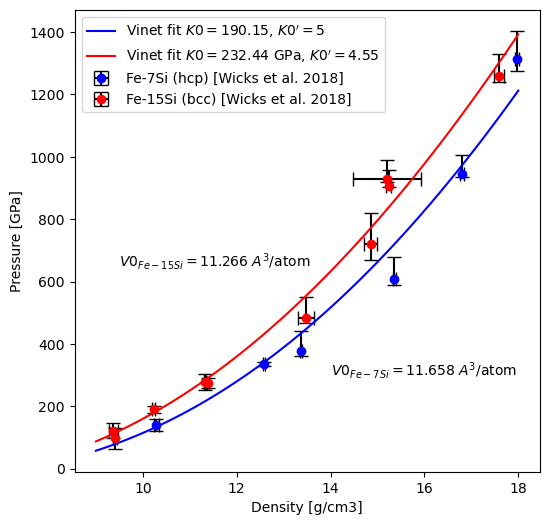

In [129]:
# create subplot figure 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

rho_7, rho_ex7, rho_err7, p7, p_err_l7, p_err_u7 = [], [], [], [], [], []
rho_15, rho_ex15, rho_err15, p15, p_err_l15, p_err_u15 = [], [], [], [], [], []

rho = np.linspace(9, 18, 100)  # Density range for fitting 

for key in ex.keys():
    if key == 'items':
        continue
    if key == 'units':
        continue
    
    if ex[key]['wtSi'] == 7:
        clr7 = 'blue'
        p7.append(ex[key]['P'])
        p_err_l7.append(ex[key]['-sP'])
        p_err_u7.append(ex[key]['+sP'])
        rho_7.append(ex[key]['rho'])
        rho_err7.append(ex[key]['srho'])
    
    else:   
        clr15 = 'red'
        p15.append(ex[key]['P'])
        p_err_l15.append(ex[key]['-sP'])
        p_err_u15.append(ex[key]['+sP'])
        rho_15.append(ex[key]['rho'])
        rho_err15.append(ex[key]['srho'])

Fe7Si = min_type('hcp',a=2.2857,c=3.6903)
Fe15Si = min_type('bcc',d=1.7740)

initial_guess_7 = [Fe7Si[1], Fe7Si[2]]
initial_guess_15 = [Fe15Si[1], Fe15Si[2]]

print(initial_guess_15)

popt_v7, pcov_v7 = curve_fit(Vinet_fitting7, rho_7, p7, p0=initial_guess_7[0])
popt_h7, pcov_h7 = curve_fit(Holzapfel_fitting7, rho_7, p7, p0=initial_guess_7)
popt_v15, pcov_v15 = curve_fit(Vinet_fitting15, rho_15, p15, p0=initial_guess_15)
popt_h15, pcov_h15 = curve_fit(Holzapfel_fitting15, rho_15, p15, p0=initial_guess_15)

KT0_fit_v7 = popt_v7
KT0_fit_h7, KTP_fit_h7 = popt_h7
KT0_fit_v15, KTP_fit_v15 = popt_v15
KT0_fit_h15, KTP_fit_h15 = popt_h15

print(popt_h15)

p_fitted_v7 = Vinet_fitting7(rho, *popt_v7)
p_fitted_h7 = Holzapfel_fitting7(rho, *popt_h7)
p_fitted_v15 = Vinet_fitting15(rho, *popt_v15)
p_fitted_h15 = Holzapfel_fitting15(rho, *popt_h15)

ax.errorbar(rho_7, p7, yerr=[p_err_l7, p_err_u7], xerr=rho_err7, fmt='o', capsize=5, color=clr7, ecolor='k', label='Fe-7Si (hcp) [Wicks et al. 2018]')
ax.errorbar(rho_15, p15, yerr=[p_err_l15, p_err_u15], xerr=rho_err15, fmt='o', capsize=5, color=clr15, ecolor='k', label='Fe-15Si (bcc) [Wicks et al. 2018]')

ax.plot(rho, p_fitted_v7, '-', color=clr7, label=f'Vinet fit $K0 = ${KT0_fit_v7[0]:.2f}, $K0\' = $5')
#ax.plot(rho, p_fitted_h7, '-', color='lightblue', label=f'Holzapfel fit $K0 = ${KT0_fit_h7:.2f} GPa, $K0\' = ${KTP_fit_h7:.2f}')
ax.plot(rho, p_fitted_v15, '-', color=clr15, label=f'Vinet fit $K0 = ${KT0_fit_v15:.2f} GPa, $K0\' = ${KTP_fit_v15:.2f}')
#ax.plot(rho, p_fitted_h15, '-', color='orange', label=f'Holzapfel fit $K0 = ${KT0_fit_h15:.2f} GPa, $K0\' = ${KTP_fit_h15:.2f}')

ax.text(9.5, 650, r'$V0_{Fe-15Si} = 11.266$ $A^3$/atom')
ax.text(14, 300, r'$V0_{Fe-7Si} = 11.658$ $A^3$/atom')

ax.set_ylabel('Pressure [GPa]')
ax.set_xlabel('Density [g/cm3]')  
ax.legend()

From the Fe-7Si alloy when fixing K0' to 5.0 gives a Vinet fit value of K0 = 190.15 GPa,
which is nicely in the error margin of the 183.4 +- 7.4 GPa found by Wicks et al. 2018.

In [137]:
MFe = 55.845  # Molar mass of iron [g/mol]
MSi = 28.0855  # Molar mass of silicon [g/mol]
wFe = 0.85
wSi = 0.15
XSi = wSi / MSi / (wFe / MFe + wSi / MSi) # molar fraction of Si in Fe-15Si
print(XSi)

def alloy_conc(wSi):
    X2 =  wSi / XSi * MFe / (MFe*wSi + MSi*(1-wSi))
    X1 = 1 - X2
    return X1, X2

print(alloy_conc(0.00001))

0.25974881722697385
(0.999923450164077, 7.654983592298387e-05)
